# Fire Danger Modeling

This notebook illustrates how to define the relevant inputs to calculate the **primary metrics** for the FBP system.


In [10]:
import numpy as np
import matplotlib.pyplot as plt

from fbp import FBP
from fbp.preprocessing.layers import GeoTiffLayer, ChildLayer, Layer
from fbp.visualize import plot_fuel_map, plot_fire_intensity, plot_fire_description, plot_fuel_consumption, plot_rate_of_spread

## Load Input Layers

- Load **fuel types** as a `Layer` object from `GeoTIFF` files (class code ID and colours are compatible with the FBP Fuel Layer symbology from NRCan).  

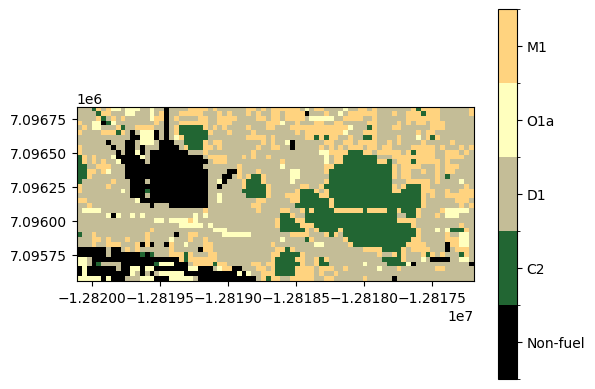

In [11]:
fuel_layer = GeoTiffLayer("sample/fuel.tif")
plot_fuel_map(fuel_map=fuel_layer.data, extent=fuel_layer.extent)

- Load **slope** and **aspect (azimuth)** as `Layer` objects from `GeoTIFF` files. 

In [12]:
layers: dict[str, Layer] = {
    "slope": GeoTiffLayer("sample/slope.tif"),
    "aspect": GeoTiffLayer("sample/aspect.tif"),
}

- Create a `slope_azimuth` layer based on the aspect layer.  

In [13]:
slope_azimuth = (layers["aspect"].data + 180) % 360
slope_azimuth_layer = ChildLayer(slope_azimuth, layers["slope"])
layers["azimuth"] = slope_azimuth_layer

- Reproject and resize all layers to ensure compatibility in **CRS** and **shape**. 

In [14]:
REF_SHAPE = fuel_layer.shape
REF_CRS = "EPSG:3857"

for name, layer in layers.items():
    layer.reproject(dst_crs=REF_CRS, method="bilinear")
    layer.resize(shape=REF_SHAPE, method="bilinear")

Source and destination CRS are the same. No reprojection needed.
Source and destination have the same size. No resizing needed.
Source and destination CRS are the same. No reprojection needed.
Source and destination have the same size. No resizing needed.
Source and destination CRS are the same. No reprojection needed.
Source and destination have the same size. No resizing needed.


- Visualize **slope** and **aspect** layers.

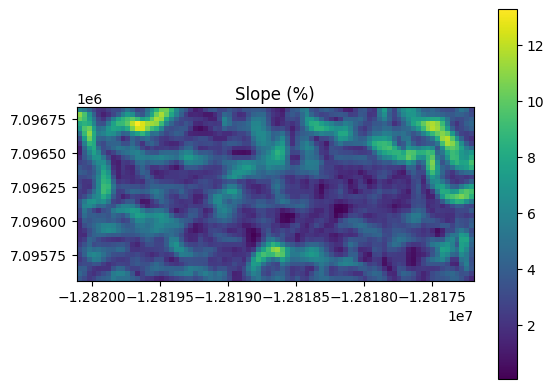

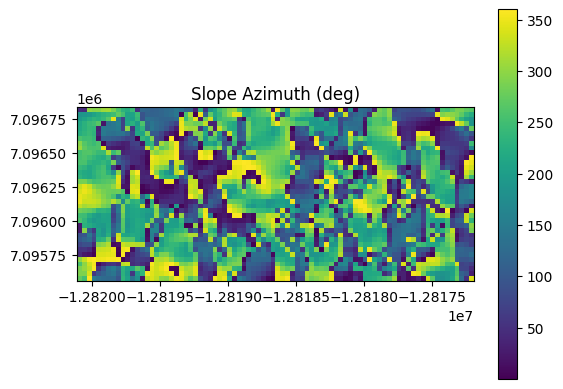

In [15]:
plt.imshow(layers["slope"].data, extent=layers["slope"].extent)
plt.colorbar()
plt.title("Slope (%)")
plt.show()

plt.imshow(layers["azimuth"].data, extent=layers["azimuth"].extent)
plt.colorbar()
plt.title("Slope Azimuth (deg)")
plt.show()

## Create FBP Model

- Generate fuel-specific variables required for FBP modeling, such as:  
  - Percent conifer map  

In [16]:
percent_conifer_map = 20 * np.ones_like(fuel_layer.data, dtype=float)


fbp_model = FBP(
    fuel_map=fuel_layer.data,
    percent_conifer=percent_conifer_map,
    slope_percent=layers["slope"].data,
    slope_azimuth=layers["azimuth"].data
)

## Run the FBP Model

Run the FBP model for a specific set of parameters, including:  

- **Fine Fuel Moisture Code (FFMC)**  
- Percent **dead balsam fir**  
- **Foliage moisture content**  
- **Built-up index**  
- **Wind speed** and **wind direction (azimuth)**  


In [17]:
ffmc = np.full_like(fuel_layer.data, 85.)  # TODO
fmc = np.full_like(fuel_layer.data, 40.0)   # TODO
bui = np.full_like(fuel_layer.data, 130.0)
ws = np.full_like(fuel_layer.data, 20.0) 
waz = np.full_like(fuel_layer.data, 0.) 

results = fbp_model.run(
    fine_fuel_moisture_content=ffmc,
    builtup_index=bui,
    percent_dead_fir=10,
    percent_grass_curing=10,
    wind_speed=ws,
    wind_azimuth=waz,
    folier_moisture_content=fmc
)

## Visualize Primary Metrics
- Visualize the outputs of the FBP model, including the primary fire danger metrics.

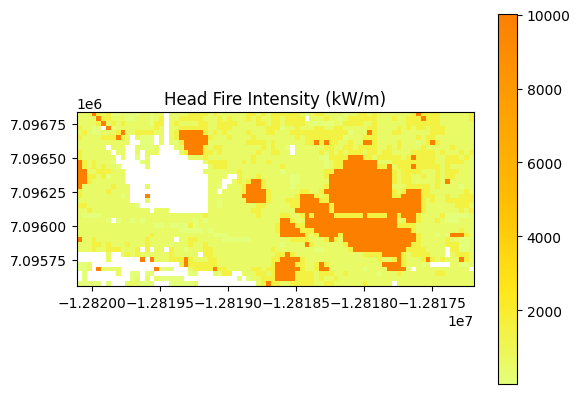

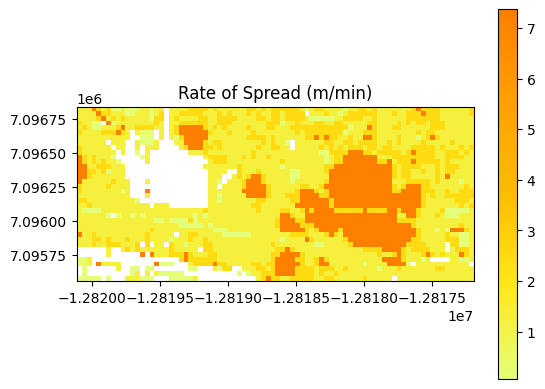

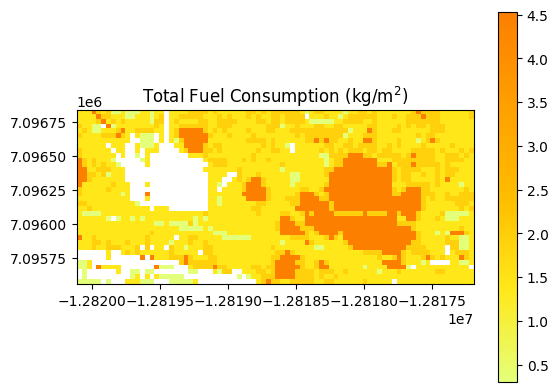

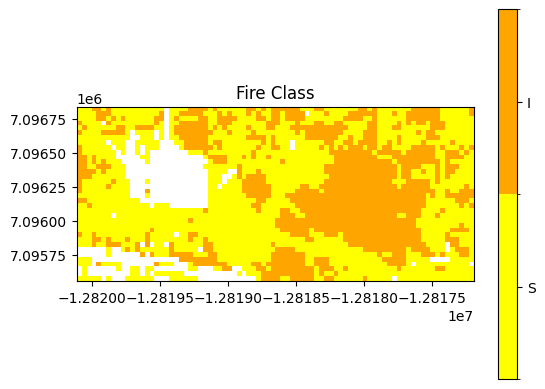

In [18]:
plot_fire_intensity(results, extent=fuel_layer.extent)
plot_rate_of_spread(results, extent=fuel_layer.extent)
plot_fuel_consumption(results, extent=fuel_layer.extent)
plot_fire_description(results, extent=fuel_layer.extent)